In [1]:
import sys
sys.path.append("./../..")

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle

from scipy.optimize import curve_fit
from scipy.stats import chisquare 

2024-07-12 12:02:09.738253: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 12:02:09.991290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 12:02:09.991364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 12:02:10.029401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 12:02:10.107480: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dt = 1e-6
Sample_frequency = 25_000 
DeltaT = 1/Sample_frequency  
TotalT = 13
transient = 3
EffectiveT = TotalT - transient

sampled_point_amount = np.int64((EffectiveT)/DeltaT) 
t = np.linspace(0., EffectiveT, sampled_point_amount) 

print("Effective simulation time: %d (s)" % EffectiveT)

Effective simulation time: 10 (s)


In [3]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [4]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

As a reference, here's a part of the function we called to compute the summary statistics on cloud. 

```python
def compute_summary_statistics(single_x_trace, single_theta, DeltaT = 1/25e3, TotalT = 10):
    summary_statistics = {}
    t = np.linspace(0., TotalT, single_x_trace.shape[0])
    t_corr = TotalT/20 # Hyperparameter
    
    [...]

    # Autocorrelation
    Cxx = stat_corr_single(single_x_trace, DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    cxx = Cxx[idx_corr]
    summary_statistics["Cxx"] = cxx  
    
    # S red
    S_red1, S_red2, S_red = stat_s_redx(Cxx, t_corr, t)
    summary_statistics["s_red1"] = S_red1
    summary_statistics["s_red2"] = S_red2
    summary_statistics["s_redx"] = S_red 

    [...]
    
    return summary_statistics
```

In [5]:
%%time
n_sim = 10
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 35.5 s, sys: 75.5 ms, total: 35.6 s
Wall time: 35.5 s


In [6]:
print("X_trace shape: ", x_trace.shape)
print("theta shape: ", theta.shape)

X_trace shape:  (10, 249999)
theta shape:  (5, 10, 1)


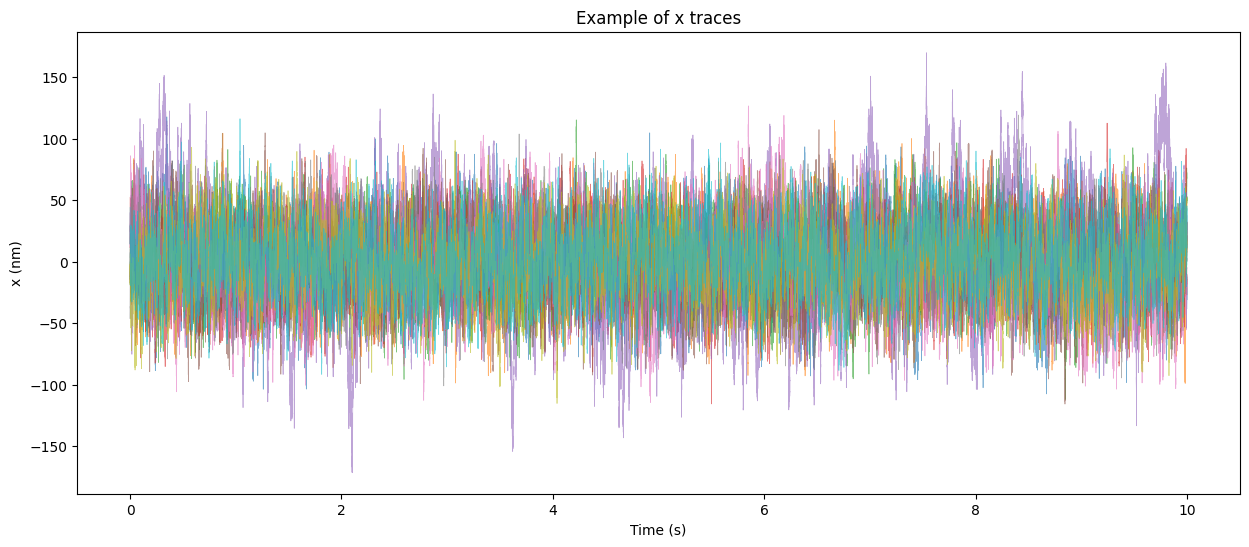

In [7]:
plt.figure(figsize=(15, 6))
plt.title("Example of x traces")
for i in range(n_sim):
    plt.plot(t, x_trace[i], alpha=0.6, lw=0.5)
plt.xlabel("Time (s)")
plt.ylabel("x (nm)");

In [8]:
def stat_s_redx(Cxx, t_corr, t, mu_x=2.8e4, k_x=6e-3, kbT=3.8):
    '''
    Computes the reduced energy production for a single x trace signal.

    INPUT
    Cxx: autocorrelation signal
    t_corr: maximum time for the correlation
    t: time array
    theta_i: parameters

    OUTPUT
    S_red: reduced x energy production
    '''
    D_x = kbT * mu_x


    # # mode "cut": cut Cxx before computing s_redx
    # if mode == "cut":
    #     idx_tau = 4*np.where(Cxx < Cxx[0]/np.e)[0][0]
    #     Cxx = Cxx[:idx_tau]
    #     t = t[:idx_tau]
        

    S1 = cumulative_trapezoid(Cxx, x=t, axis=-1, initial=0)
    S1 = cumulative_trapezoid(S1, x=t, axis=-1, initial=0)
    idx_corr = where((t>0)*(t<t_corr))[0]
    S_red1 = (Cxx[0]-Cxx[idx_corr])/(D_x*t[idx_corr]) # First term in S_red
    S_red2 = ((mu_x*k_x)**2)*S1[idx_corr]/(D_x*t[idx_corr]) # Second term in S_red
    S_red = S_red1 + S_red2 # Compute S_red



    return S_red1, S_red2, S_red

In [9]:
# Hyperparameters of the statistical functions
## Remember that TotalT does include the transient time
## Note that if t_corr > EffectiveT, idx_corr will be the same as t
t_corr = TotalT/20
t_cxx = t[where((t>0)*(t<t_corr))[0]]

# Lists to store the results
Cxx_list = []
s_red1_list = []
s_red2_list = []
s_redx_list = []

# Iterate over the simulations
for i in range(n_sim):
    ## Note that Cxx is cutted after the computation the s_redx
    ## Instead, s_redx is cutted inside stat_ the function
    Cxx = stat_corr_single(x_trace[i], DeltaT)
    
    ## The following line sets Cxx to zero when below a certain threshold
    #Cxx[6*np.where(Cxx < Cxx[0]/np.e)[0][0]:] = 0

    idx_corr = where((t>0)*(t<t_corr))[0]
    
    s_red1, s_red2, s_redx = stat_s_redx(Cxx, t_corr, t)
    
    Cxx_list.append(Cxx[idx_corr])
    s_red1_list.append(s_red1)
    s_red2_list.append(s_red2)
    s_redx_list.append(s_redx)

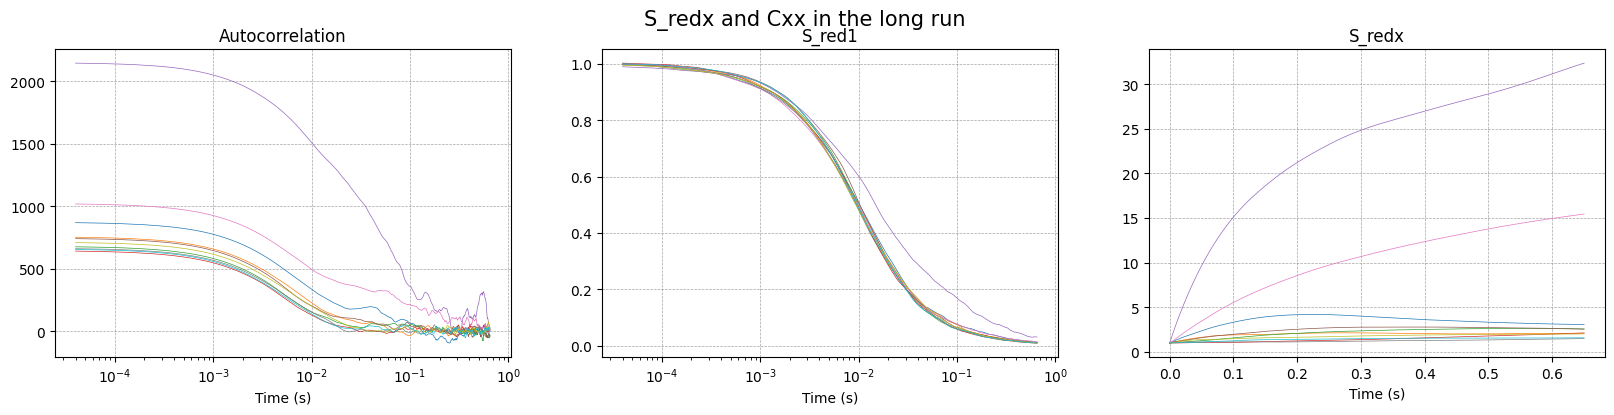

In [10]:
plt.figure(figsize=(20, 4))
plt.suptitle("S_redx and Cxx in the long run", fontsize=15)

plt.subplot(131)
plt.title("Autocorrelation")
for i in range(n_sim):
    plt.plot(t_cxx, Cxx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
#plt.yscale("log")
#plt.xlim(0, 0.9)
#plt.ylim(0, 1000)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(132)
plt.title("S_red1")
for i in range(n_sim):
    plt.plot(t_cxx, s_red1_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
plt.xscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(133)
plt.title("S_redx")
for i in range(n_sim):
    plt.plot(t_cxx, s_redx_list[i], alpha=1, lw=0.5)
plt.xlabel("Time (s)")
#plt.xscale("log")
#plt.yscale("log")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')


In [11]:
def stat_fit_corr(single_corr, DeltaT):
    # Get the temporal array
    n = len(single_corr)
    t_cxx = np.arange(0., n*DeltaT, DeltaT)[1:]

    def cxx_exp3(t, a1, a2, a3, b1, b2, b3):
        return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)
    
    # Log sample Cxx and t_cxx
    log_sample = np.logspace(0, np.log10(n-1), 100, dtype=np.int32)
    t_cxx_log = t_cxx[log_sample]
    single_corr_log = single_corr[log_sample]

    popt, pcov = curve_fit(cxx_exp3, t_cxx_log, single_corr_log, p0=[50, 100, 100, 100, 100, 100], maxfev=10000)

    return popt, cxx_exp3(t_cxx, *popt)

In [79]:
def stat_fit_s_redx(single_s_redx, single_corr, DeltaT, mode="exp"):
    """
    Fit the s_redx function
    """
    assert mode in ["exp", "simple"], "Mode not recognized"

    n = len(single_s_redx)
    t_cxx = np.linspace(0., (n+1)*DeltaT, (n+1))[1:]
    
    def s_redx_simple(t, a, tau):
        return(1 + a*t/(1+t/tau))

    def s_redx_exp(t, a1, a2, b1, b2, b3, c):
        a3 = 1 - a1 - a2 
        sum_exp = a1*np.exp(-b1*t) + (a2)*np.exp(-(b1+b2)*t) + (a3)*np.exp(-(b1+b2+b3)*t)
        sum = a1*b1 + (a2)*(b1+b2) + (a3)*(b1+b2+b3)
        tau = 1/sum
        return(1 + c - (c*tau/t)*(1-sum_exp))
    
    if mode == "exp":
        # # Cut based on the decay of Cxx
        # # Get the first index for which Cxx < Cxx[0]/2
        # idx_tau = np.where(single_corr < single_corr[0]/np.e)[0][0]
        # n_tau = 50
        # # Cut s_redx and t_cxx
        # cut = np.min([n-1, n_tau*idx_tau])
        # t_cxx_fit = t_cxx[:cut]
        # single_s_redx_fit = single_s_redx[:cut]

        # log subsampling
        log_sample = np.logspace(0, np.log10(n-1), 100, dtype=np.int32)
        t_cxx_fit = t_cxx[log_sample]
        single_s_redx_fit = single_s_redx[log_sample]
        

        try: 
            popt, pcov = curve_fit(s_redx_exp, t_cxx_fit, single_s_redx_fit, p0=[1, 10, 10, 0.1, 0.01, 10],
                          bounds=([0, 0, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]), maxfev=5000)
            #print(chisquare(single_s_redx_fit, s_redx_exp(t_cxx_fit, *popt)))
        except:
            return np.zeros(6), np.zeros(len(t_cxx))
        return popt, s_redx_exp(t_cxx, *popt)


    if mode == "simple":
        t_cxx_fit = t_cxx[::6]
        single_s_redx_fit = single_s_redx[::6]
        try:
            popt, pcov = curve_fit(s_redx_simple, t_cxx_fit, single_s_redx_fit, p0=[1e3, 1e-2],
                          bounds=([0, 0], [np.inf, np.inf]), maxfev=5000)
        except:
            return np.zeros(6), np.zeros(len(t_cxx))
        return popt, s_redx_simple(t_cxx, *popt)

/tmp/ipykernel_3839/2958230844.py:7: RuntimeWarning: overflow encountered in exp
  return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)
/tmp/ipykernel_3839/2958230844.py:7: RuntimeWarning: invalid value encountered in add
  return a1*np.exp(-b1*t) + a2*np.exp(-b2*t) + a3*np.exp(-b3*t)


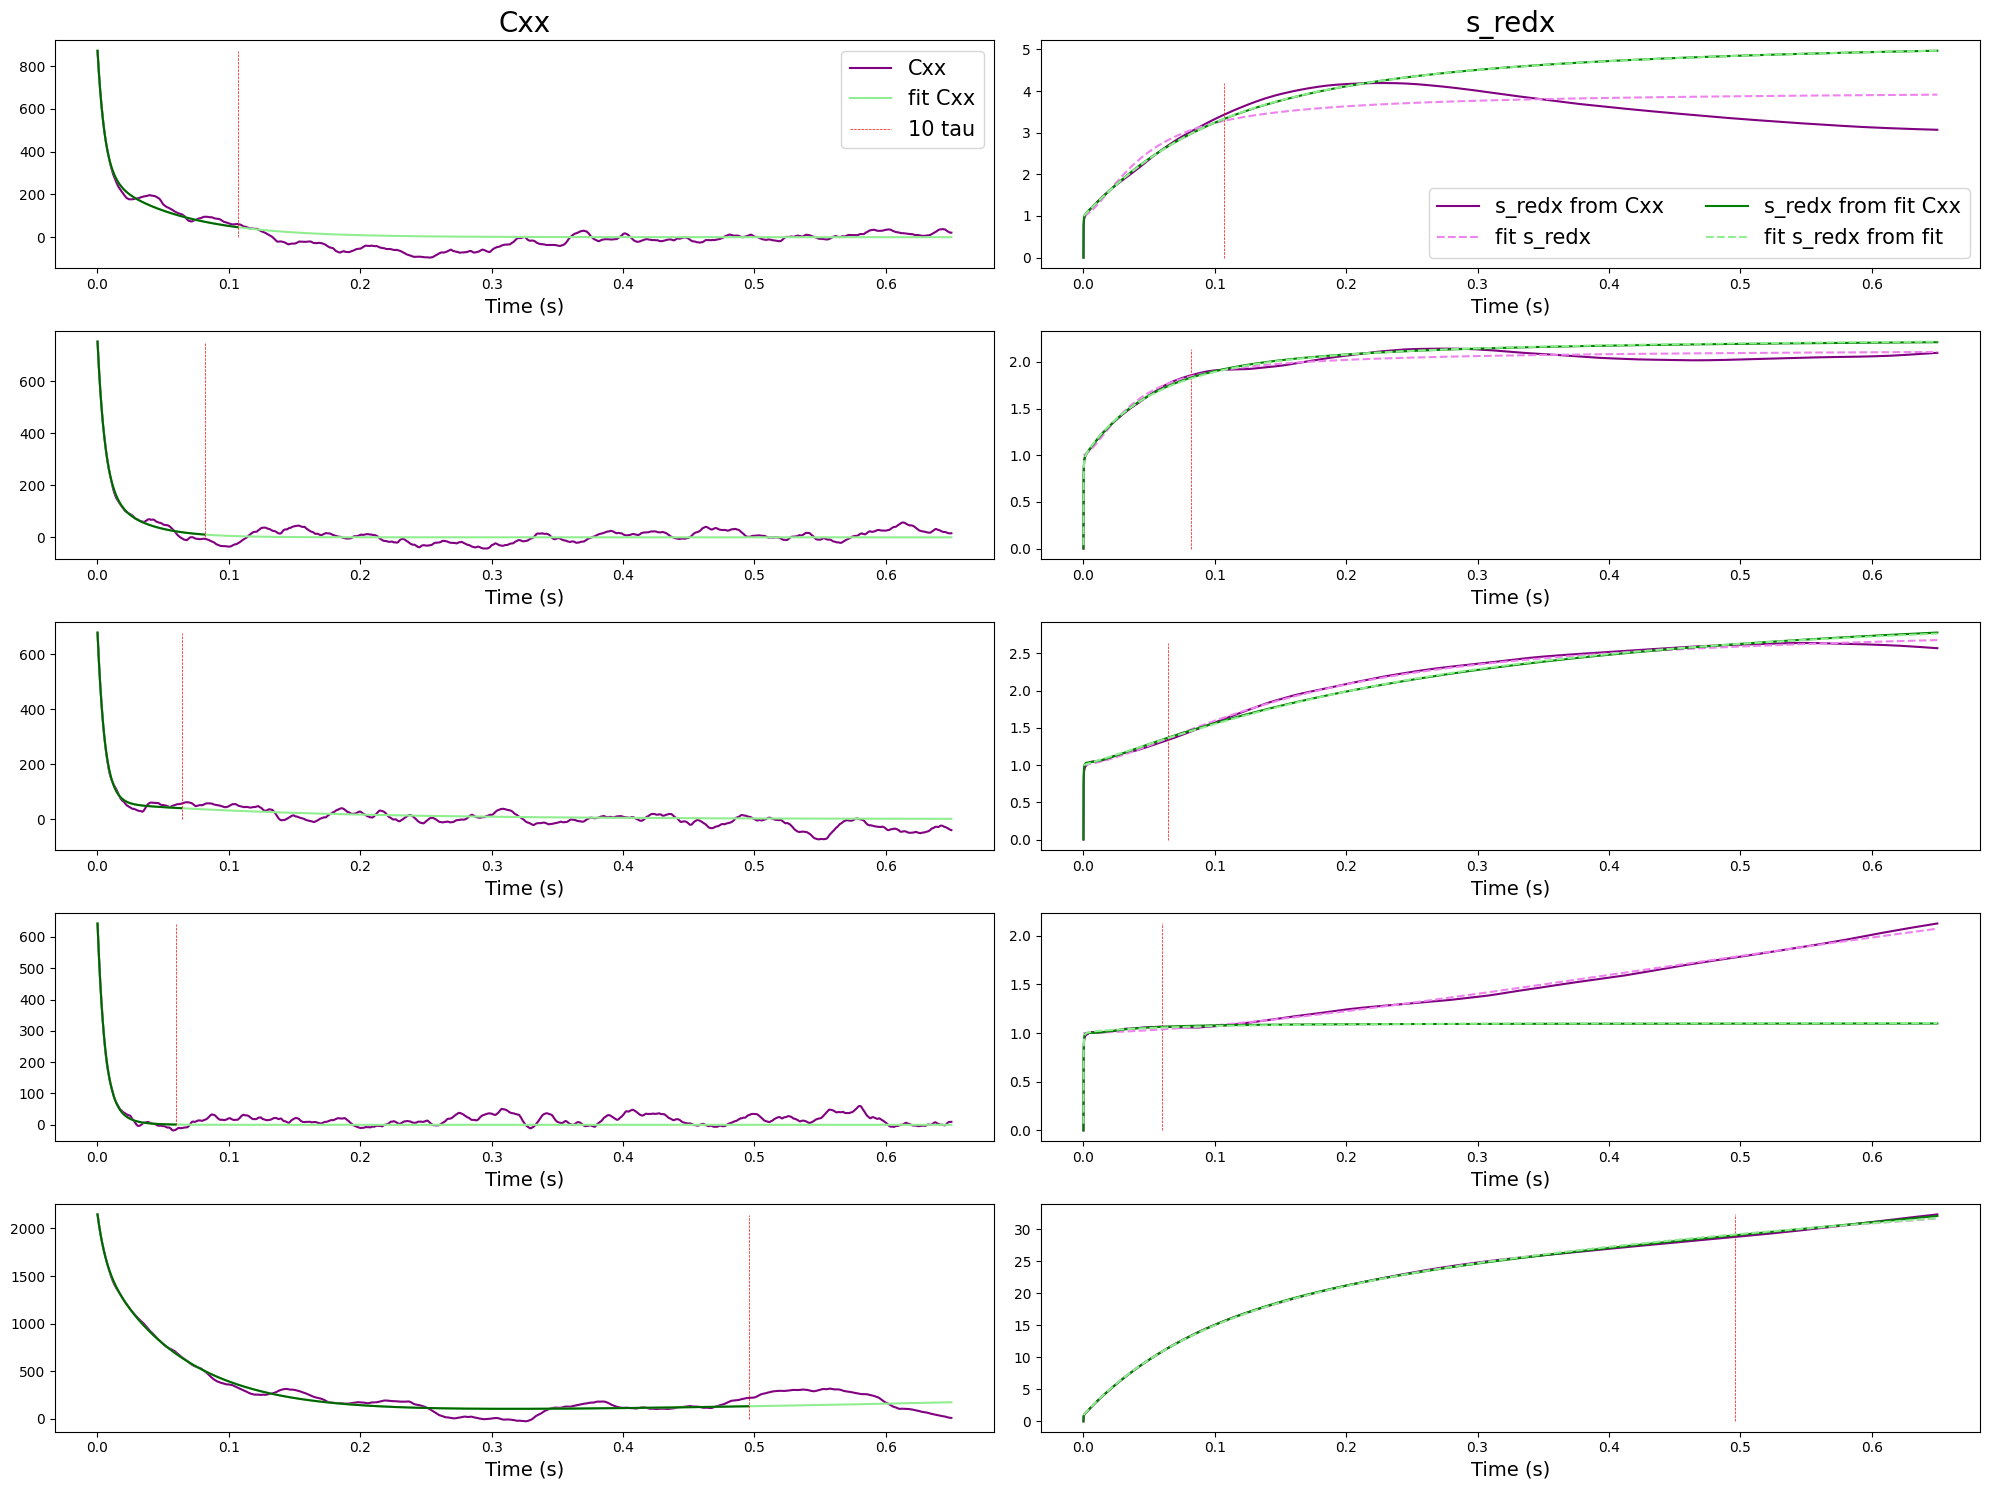

In [80]:
fig, ax = plt.subplots(5, 2, figsize=(20, 15))
ax = ax.ravel()


t_corr = TotalT/20
t_cxx = t[where((t>0)*(t<t_corr))[0]]
idx_corr = where((t>0)*(t<t_corr))[0]

ax[0].set_title("Cxx", fontsize=15)
ax[1].set_title("s_redx", fontsize=15)

for i in range(5):

    ### Cxx ###
    ax[2*i].set_xlabel("Time (s)", fontsize=14)

    # Compute Cxx and cut it
    Cxx_full = stat_corr_single(x_trace[i], DeltaT)
    Cxx = Cxx_full[idx_corr]
    
    # Fit Cxx
    popt_cxx, fit_cxx = stat_fit_corr(Cxx, DeltaT)

    # Plot Cxx
    ax[2*i].plot(t_cxx, Cxx, label="Cxx", color="purple")
    ax[2*i].plot(t_cxx, fit_cxx, label="fit Cxx", color="lightgreen")
    
    
    # Cut the fit the Cxx according to its decay
    idx_tau = np.where(Cxx < Cxx[0]/np.e)[0][0]
    n_tau = 10
    ax[2*i].vlines(n_tau*t_cxx[idx_tau], 0, Cxx[0], linestyle="--", color="red", lw=0.5, label=str(n_tau)+" tau")
    
    fit_cxx_cut = fit_cxx[:n_tau*idx_tau]
    t_cxx_cut = t_cxx[:n_tau*idx_tau]
    ax[2*i].plot(t_cxx_cut, fit_cxx_cut, color="darkgreen")


    ### s_redx ###
    ax[2*i+1].set_xlabel("Time (s)", fontsize=14)
    
    # Compute s_redx from Cxx 
    ## Note that computing s_redx from the Cxx within n*tau is equivalent to cut it in the aftermath
    s_red1, s_red2, s_redx = stat_s_redx(Cxx, t_corr, t_cxx)
    ax[2*i+1].plot(t_cxx, s_redx, label="s_redx from Cxx", color="purple")
    ax[2*i+1].vlines(n_tau*t_cxx[idx_tau], 0, np.max(s_redx), linestyle="--", color="red", lw=0.5)
    
    popt, fit_exp = stat_fit_s_redx(s_redx, Cxx, DeltaT, mode="exp")
    ax[2*i+1].plot(t_cxx, fit_exp, "--", color="violet", label="fit s_redx")

    # Compute s_redx from the uncutted-fitted Cxx
    s_red1, s_red2, s_redx = stat_s_redx(fit_cxx, t_corr, t_cxx)
    ax[2*i+1].plot(t_cxx, s_redx, label="s_redx from fit Cxx", color="green")

    popt, fit_exp = stat_fit_s_redx(s_redx, Cxx, DeltaT, mode="exp")
    ax[2*i+1].plot(t_cxx, fit_exp, "--", color="lightgreen", label="fit s_redx from fit")

    

ax[0].set_title("Cxx", fontsize=20)
ax[0].legend(fontsize=15)
ax[1].set_title("s_redx", fontsize=20)
ax[1].legend(fontsize=15, ncols=2)

fig.tight_layout()
    
    